In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack

import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Input, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import concatenate, Dropout
from keras.utils import to_categorical
from tensorflow.keras import optimizers
import seaborn as sns

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'C:/Users/khw/2023DeepLearning/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'C:/Users/khw/2023DeepLearning/human+activity+recognition+using+smartphones/UCI HAR Dataset/UCI HAR Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

In [3]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


In [4]:
## set number of epochs and batch size
batch_size = 64
validation_split = 0.2

In [5]:
from keras.layers import Bidirectional

n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Bidirectional(LSTM(100), input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
# fit network
train_epochs = 10
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/10
92/92 [==============================] - 76s 653ms/step - loss: 1.1490 - accuracy: 0.5203 - val_loss: 0.9828 - val_accuracy: 0.6200
Epoch 2/10
92/92 [==============================] - 55s 600ms/step - loss: 0.7864 - accuracy: 0.6795 - val_loss: 0.7902 - val_accuracy: 0.6995
Epoch 3/10
92/92 [==============================] - 61s 666ms/step - loss: 0.5932 - accuracy: 0.7694 - val_loss: 0.7378 - val_accuracy: 0.7791
Epoch 4/10
92/92 [==============================] - 67s 730ms/step - loss: 0.5279 - accuracy: 0.7988 - val_loss: 0.6540 - val_accuracy: 0.7607
Epoch 5/10
92/92 [==============================] - 46s 493ms/step - loss: 0.4531 - accuracy: 0.8306 - val_loss: 0.5502 - val_accuracy: 0.8368
Epoch 6/10
92/92 [==============================] - 42s 454ms/step - loss: 0.3538 - accuracy: 0.8745 - val_loss: 0.6371 - val_accuracy: 0.8015
Epoch 7/10
92/92 [==============================] - 54s 593ms/step - loss: 0.3961 - accuracy: 0.8453 - val_loss: 0.5835 - val_accuracy: 0.8226

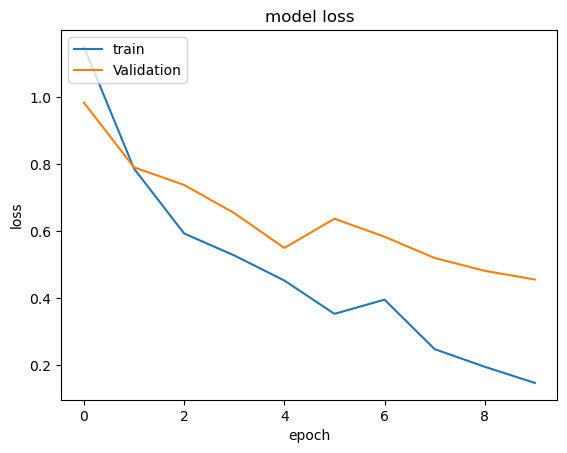

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

In [9]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the BiLSTM model", test_accuracy)
# Get the predictions for the test set
predictions = model.predict(testX)

Accuracy of the BiLSTM model 0.8710553050041199
93/93 [==============================] - 7s 45ms/step


In [10]:
predictions

array([[7.30939908e-04, 3.40370811e-04, 2.94583388e-05, 1.25148334e-02,
        9.86271262e-01, 1.13101996e-04],
       [4.06223815e-04, 2.28741381e-04, 1.60971358e-05, 1.23465126e-02,
        9.86915946e-01, 8.65176771e-05],
       [4.77332127e-04, 2.43104354e-04, 1.66959962e-05, 1.21011529e-02,
        9.87077832e-01, 8.38721171e-05],
       ...,
       [2.00103456e-03, 9.94196415e-01, 3.67467524e-03, 6.50549964e-06,
        1.00323501e-04, 2.10043345e-05],
       [1.47504006e-02, 9.79360998e-01, 3.98351019e-03, 5.77644423e-05,
        1.41939614e-03, 4.27924970e-04],
       [1.78848524e-02, 9.80070770e-01, 1.09335571e-03, 2.34362506e-05,
        4.86634235e-04, 4.40889882e-04]], dtype=float32)

In [11]:
def display_results(testy,predictions,classNames):
    y_test=np.argmax(testy, axis=1)
    y_scores=np.argmax(predictions, axis=1)
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_scores)
    print("**** Confusion Matrix ****")
    print(cm)
    print("**** Classification Report ****")
    print(classification_report(y_test, y_scores, target_names=classNames))
    con = np.zeros((classes,classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] #/np.sum(cm[x,:])

    plt.figure(figsize=(10,8))
    df = sns.heatmap(con, annot=True, fmt='g', cmap='Blues',xticklabels= classNames , yticklabels= classNames)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

**** Confusion Matrix ****
[[424  33  34   5   0   0]
 [ 19 407  45   0   0   0]
 [  2  12 406   0   0   0]
 [  0  19   0 399  68   5]
 [  2   2   0  91 437   0]
 [  0  28  15   0   0 494]]
**** Classification Report ****
              precision    recall  f1-score   support

           1       0.95      0.85      0.90       496
           2       0.81      0.86      0.84       471
           3       0.81      0.97      0.88       420
           4       0.81      0.81      0.81       491
           5       0.87      0.82      0.84       532
           6       0.99      0.92      0.95       537

    accuracy                           0.87      2947
   macro avg       0.87      0.87      0.87      2947
weighted avg       0.88      0.87      0.87      2947



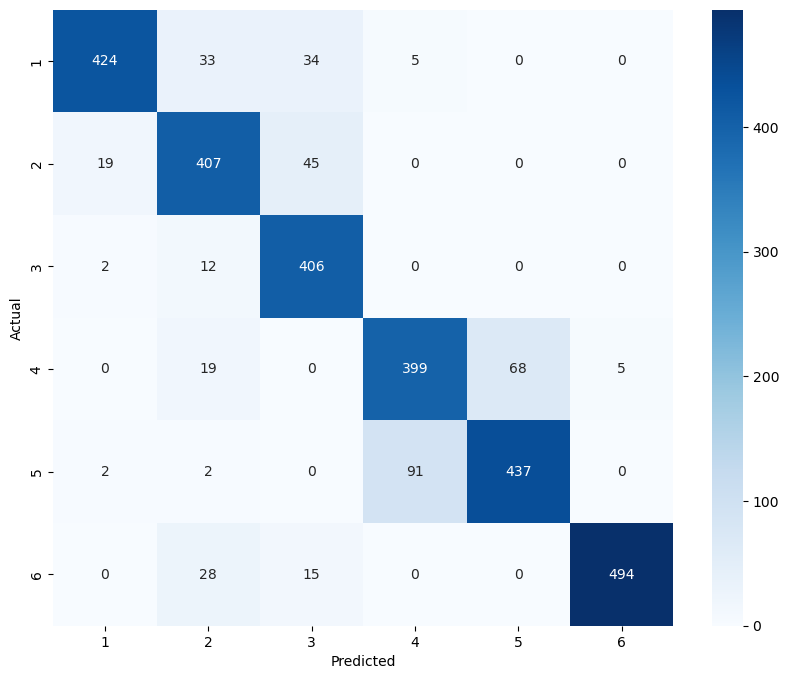

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
classNames=["1","2","3","4","5","6"]
display_results(testy,predictions,classNames)